In [1]:
import numpy as np
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from plotly import express as px
import plotly.graph_objs as go
# ML libraries - idk which one to use yet
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error, r2_score
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import preprocessing, tree
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial import cKDTree


In [2]:
# NASA API
def get_nasa_power_data(lat, lon, start_date, end_date):
    """
    Fetches NASA POWER API data for given latitude, longitude, and time range.

    Args:
    - lat (float): Latitude of the location.
    - lon (float): Longitude of the location.
    - start_date (str): Start date in YYYYMMDD format.
    - end_date (str): End date in YYYYMMDD format.

    Returns:
    - Pandas DataFrame with selected weather parameters.
    """

    # Specify multiple parameters in the API request
    parameters = "PRECSNO,T2MDEW,PRECTOTCORR,T2M,WS2M"

    url = "https://power.larc.nasa.gov/api/temporal/daily/point"
    params = {
        "parameters": parameters,
        "community": "RE",
        "longitude": lon,
        "latitude": lat,
        "start": start_date,
        "end": end_date,
        "format": "JSON"
    }

    response = requests.get(url, params=params)

    data = response.json()

    # Convert JSON response to DataFrame and transpose it
    nasa_weather = pd.DataFrame.from_dict(data["properties"]["parameter"], orient="index").T

    # Reset index and rename date column
    nasa_weather.reset_index(inplace=True)
    nasa_weather.rename(columns={"index": "date"}, inplace=True)

    # Convert date column to proper datetime format
    nasa_weather["date"] = pd.to_datetime(nasa_weather["date"], format="%Y%m%d", errors="coerce")
    nasa_weather.dropna(subset=["date"], inplace=True)  # Remove invalid date rows

    nasa_weather.rename(columns={
        "PRECSNO": "Snow_Precipitation",
        "T2MDEW": "Dew_Point_2m",
        "PRECTOTCORR": "Total_Precipitation_mm",
        "T2M": "Temperature_2m_C",
        "WS2M": "Wind_Speed_2m"
    }, inplace=True)
    
    # Add Rounded_Lat and Rounded_Lng for merging
    nasa_weather['Rounded_Lat'] = lat
    nasa_weather['Rounded_Lng'] = lon
    
    # Display DataFrame
    print(f"\n Weather Data for Latitude {lat}, Longitude {lon}\n")
    print(f"\n Weather Data for Latitude {lat}, Longitude {lon}\n")
    nasa_weather['Precipitation(in)'] = nasa_weather['Total_Precipitation_mm'] / 25.4 # mm to in
    nasa_weather['Temperature(F)'] = (nasa_weather['Temperature_2m_C'] * (9./5.)) + 32. # C to F
    nasa_weather['Wind_Speed(mph)'] = nasa_weather['Wind_Speed_2m'] * 2.237 # m/s to mph
    # nasa_weather.dropna()
    display(nasa_weather)  # Works in Jupyter Notebook

    return nasa_weather

In [3]:
# Example: Fetch data for different locations
df_la = get_nasa_power_data(34.05, -118.25, "20240101", "20240107")  # Los Angeles


 Weather Data for Latitude 34.05, Longitude -118.25


 Weather Data for Latitude 34.05, Longitude -118.25



,date,Snow_Precipitation,Dew_Point_2m,Total_Precipitation_mm,Temperature_2m_C,Wind_Speed_2m,Rounded_Lat,Rounded_Lng,Precipitation(in),Temperature(F),Wind_Speed(mph)
0,2024-01-01,0.0,6.12,0.04,12.14,1.64,34.05,-118.25,0.001575,53.852,3.66868
1,2024-01-02,0.0,7.05,0.09,11.55,1.59,34.05,-118.25,0.003543,52.790,3.55683
2,2024-01-03,0.0,6.75,5.87,10.86,3.25,34.05,-118.25,0.231102,51.548,7.27025
3,2024-01-04,0.0,2.14,0.02,9.76,2.89,34.05,-118.25,0.000787,49.568,6.46493
4,2024-01-05,0.0,1.99,0.00,10.80,2.00,34.05,-118.25,0.000000,51.440,4.47400
5,2024-01-06,0.0,1.23,0.12,10.50,2.86,34.05,-118.25,0.004724,50.900,6.39782
6,2024-01-07,0.0,-0.09,0.26,7.77,5.29,34.05,-118.25,0.010236,45.986,11.83373


In [4]:
# inspect us_accident data
us_accidents = pd.read_csv('US_Accidents_March23.csv')
us_accidents.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,...,False,False,False,False,True,False,Day,Day,Day,Day


In [5]:
# string feature that if kept will need to be encoded for ML
str_features = 'Weather_Condition'

# Exploratory Analysis

/var/folders/6p/qg9drb2j44184d4xykh5lzqc0000gn/T/ipykernel_1575/875793009.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


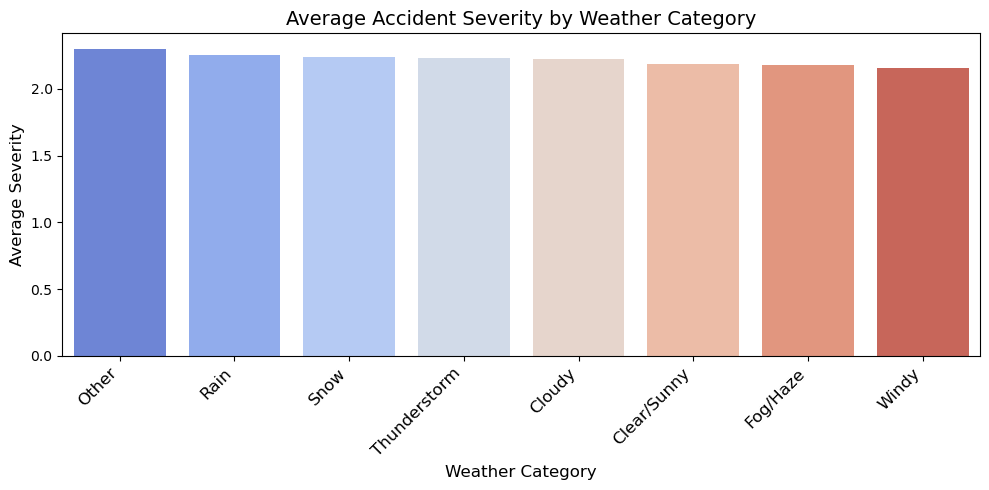

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define broad weather categories
weather_mapping = {
    "Rain": ["Rain", "Drizzle", "Showers", "Thunderstorms", "Light Rain", "Heavy Rain", "Scattered Showers"],
    "Snow": ["Snow", "Blowing Snow", "Sleet", "Heavy Snow", "Flurries", "Light Snow", "Freezing Rain", "Snow Showers"],
    "Windy": ["Windy", "Gusty Winds", "Blowing Dust", "Dust Storm", "Strong Wind"],
    "Thunderstorm": ["Thunderstorm", "T-Storm", "Heavy Thunderstorms", "Severe Thunderstorms"],
    "Fog/Haze": ["Fog", "Haze", "Mist", "Patchy Fog", "Dense Fog"],
    "Clear/Sunny": ["Clear", "Fair", "Sunny", "Partly Cloudy", "Mostly Clear"],
    "Cloudy": ["Cloudy", "Overcast", "Mostly Cloudy", "Partly Cloudy"],
}

# Function to categorize weather conditions
def categorize_weather(condition):
    if pd.isna(condition):  # Check for NaN values
        return "Other"
    
    condition = str(condition)  # Ensure it's a string
    for category, keywords in weather_mapping.items():
        if any(keyword in condition for keyword in keywords):
            return category
    return "Other"  # Default category for uncategorized conditions

# Convert NaNs and apply categorization
us_accidents["Weather_Condition"] = us_accidents["Weather_Condition"].astype(str).fillna("Unknown")
us_accidents["Weather_Category"] = us_accidents["Weather_Condition"].apply(categorize_weather)

# Use the correct DataFrame name (should match `us_accidents`)
weather_severity_grouped = us_accidents.groupby("Weather_Category")["Severity"].mean().reset_index()

# Sort by severity
weather_severity_grouped = weather_severity_grouped.sort_values(by="Severity", ascending=False)

# Plot with improved readability
plt.figure(figsize=(10, 5))
sns.barplot(
    x="Weather_Category",
    y="Severity",
    data=weather_severity_grouped,
    palette="coolwarm"
)

# Improve readability
plt.xticks(rotation=45, fontsize=12, ha="right")  # Rotate labels for clarity
plt.title("Average Accident Severity by Weather Category", fontsize=14)
plt.xlabel("Weather Category", fontsize=12)
plt.ylabel("Average Severity", fontsize=12)
plt.tight_layout()

# Show plot
plt.show()


/var/folders/6p/qg9drb2j44184d4xykh5lzqc0000gn/T/ipykernel_1575/568404271.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Weather_Category", y="Severity", data=us_accidents, palette="coolwarm")


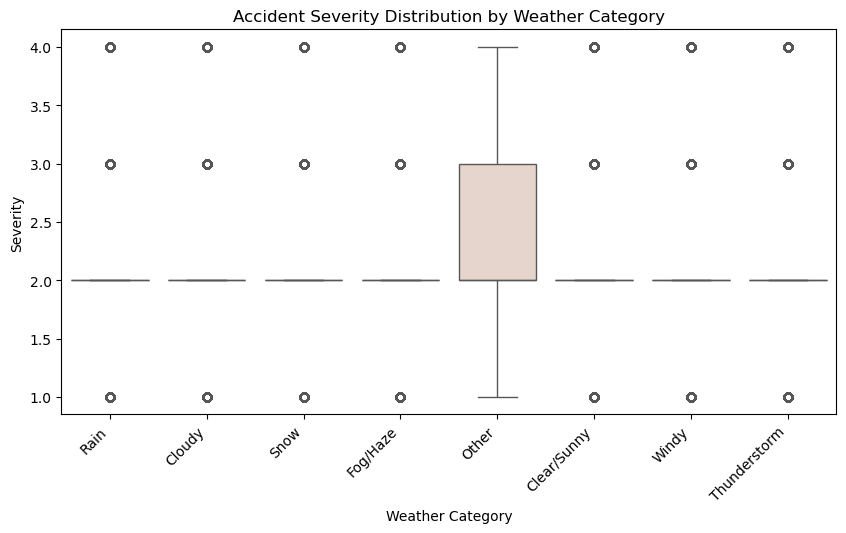

In [7]:
plt.figure(figsize=(10, 5))
sns.boxplot(x="Weather_Category", y="Severity", data=us_accidents, palette="coolwarm")
plt.xticks(rotation=45, ha="right")
plt.title("Accident Severity Distribution by Weather Category")
plt.xlabel("Weather Category")
plt.ylabel("Severity")
plt.show()


/var/folders/6p/qg9drb2j44184d4xykh5lzqc0000gn/T/ipykernel_1575/1216920648.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['Severity'], palette='viridis')


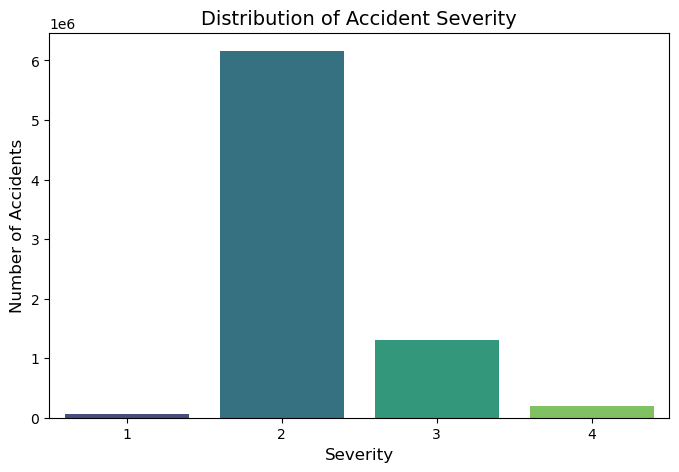

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_severity_distribution(df):
    plt.figure(figsize=(8,5))
    sns.countplot(x=df['Severity'], palette='viridis')
    plt.title('Distribution of Accident Severity', fontsize=14)
    plt.xlabel('Severity', fontsize=12)
    plt.ylabel('Number of Accidents', fontsize=12)
    plt.show()

plot_severity_distribution(us_accidents)


/var/folders/6p/qg9drb2j44184d4xykh5lzqc0000gn/T/ipykernel_1575/1041791482.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df[feature], y=df['Severity'], ax=axes[i], palette='pastel')
/var/folders/6p/qg9drb2j44184d4xykh5lzqc0000gn/T/ipykernel_1575/1041791482.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df[feature], y=df['Severity'], ax=axes[i], palette='pastel')
/var/folders/6p/qg9drb2j44184d4xykh5lzqc0000gn/T/ipykernel_1575/1041791482.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df[feature], y=df['Severity'], ax=axes

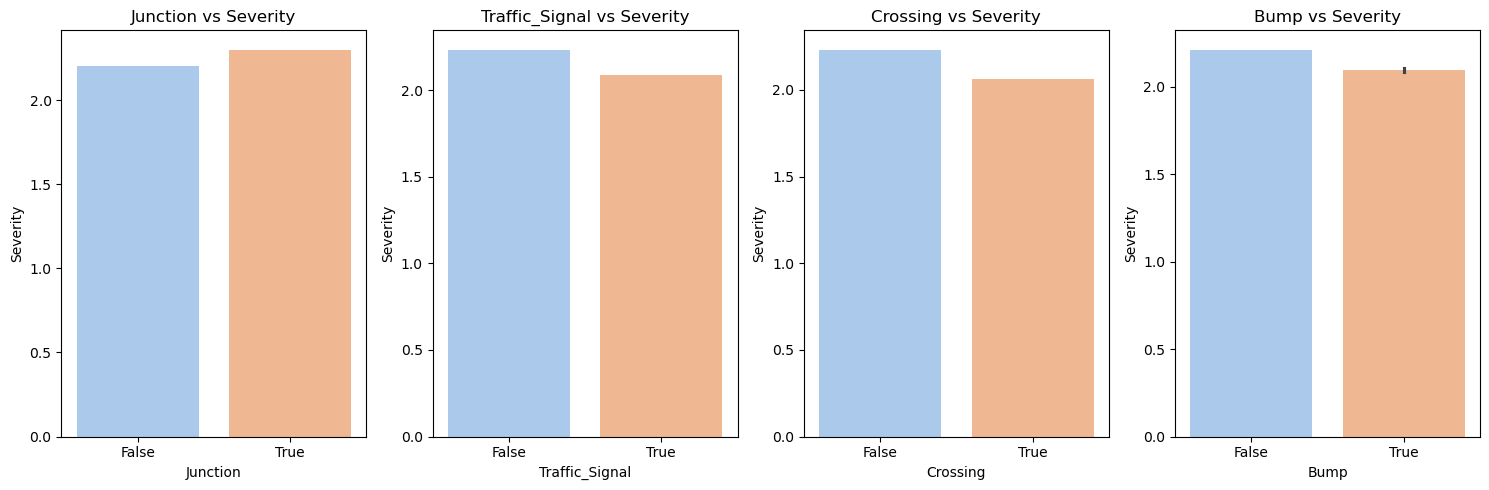

In [11]:
def plot_binary_features_vs_severity(df, features):
    fig, axes = plt.subplots(1, len(features), figsize=(15,5))
    for i, feature in enumerate(features):
        sns.barplot(x=df[feature], y=df['Severity'], ax=axes[i], palette='pastel')
        axes[i].set_title(f'{feature} vs Severity')
    plt.tight_layout()
    plt.show()

road_features = ['Junction', 'Traffic_Signal', 'Crossing', 'Bump']
plot_binary_features_vs_severity(us_accidents, road_features)


As you can see from these graphs, the road features also do not contribute significantly to severity.

In [12]:
us_accidents['Start_Time'] = us_accidents['Start_Time'].str.replace(r'\.\d+$', '', regex=True) # removes the fractional seconds (.000000000)
us_accidents['End_Time'] = us_accidents['End_Time'].str.replace(r'\.\d+$', '', regex=True) 
a
us_accidents['Start_Time'] = pd.to_datetime(us_accidents['Start_Time']) 
us_accidents['End_Time'] = pd.to_datetime(us_accidents['End_Time'])

In [13]:
import matplotlib.ticker as ticker

incident_counts_by_time = us_accidents['Start_Time'].dt.hour.value_counts().sort_index()
incident_counts_by_day = us_accidents['Start_Time'].dt.day_name().value_counts().sort_index()
incident_counts_by_week = us_accidents['Start_Time'].dt.isocalendar().week.value_counts().sort_index()
incident_counts_by_month = us_accidents['Start_Time'].dt.month_name().value_counts().sort_index()
incident_counts_by_year = ['Start_Time'].dt.year.value_counts().sort_index()

fig, axs = plt.subplots(3, 2, figsize=(15, 15))

axs[0, 0].bar(incident_counts_by_time.index, incident_counts_by_time.values, color='skyblue')
axs[0, 0].set_title('Number of Incidents by Hour of the Day', fontsize=14)
axs[0, 0].set_xlabel('Hour of the Day', fontsize=12)
axs[0, 0].set_ylabel('Number of Incidents', fontsize=12)

axs[0, 1].bar(incident_counts_by_day.index, incident_counts_by_day.values, color='lightgreen')
axs[0, 1].set_title('Number of Incidents by Day of the Week', fontsize=14)
axs[0, 1].set_xlabel('Day of the Week', fontsize=12)
axs[0, 1].set_ylabel('Number of Incidents', fontsize=12)

axs[1, 0].bar(incident_counts_by_week.index.astype(int), incident_counts_by_week.values, color='salmon')
axs[1, 0].set_title('Number of Incidents by Week of the Year', fontsize=14)
axs[1, 0].set_xlabel('Week of the Year', fontsize=12)
axs[1, 0].set_ylabel('Number of Incidents', fontsize=12)

axs[1, 1].bar(incident_counts_by_month.index, incident_counts_by_month.values, color='lightcoral')
axs[1, 1].set_title('Number of Incidents by Month', fontsize=14)
axs[1, 1].set_xlabel('Month', fontsize=12) 
axs[1, 1].set_ylabel('Number of Incidents', fontsize=12)
axs[1, 1].tick_params(axis='x', labelrotation=90)

axs[2, 0].bar(incident_counts_by_year.index, incident_counts_by_year.values, color='lightblue')
axs[2, 0].set_title('Number of Incidents by Year', fontsize=14)
axs[2, 0].set_xlabel('Year', fontsize=12)
axs[2, 0].set_ylabel('Number of Incidents', fontsize=12)

axs[2, 1].axis('off')

for ax in axs.flat:
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))

plt.tight_layout()
plt.show()

AttributeError: 'list' object has no attribute 'dt'

# Deep Learning using TensorFlow

In [ ]:
# list of all columns in US Accident Data
drop_cols = ['ID',
            'Source',
            # 'Severity', # Severity = target column, 1-4, where 1 indicates the least impact on traffic
            'Start_Time',
            'End_Time',
            'Start_Lat',  
            'Start_Lng', 
            'End_Lat',
            'End_Lng',
            'Distance(mi)', # Distance(mi) = target column?, length of road extent affected by accident in miles
            'Description', # Description = human description of accident
            'Street', 
            'City', 
            'County',
            'State',
            'Zipcode',
            'Country',
            'Timezone',
            'Airport_Code',
            'Weather_Timestamp', # Weather_Timestamp = shows time-stamp of weather observation record (in local time)
            # 'Temperature(F)',
            'Wind_Chill(F)',
            'Humidity(%)',
            'Pressure(in)',
            'Visibility(mi)',
            'Wind_Direction',
            # 'Wind_Speed(mph)',
            # 'Precipitation(in)',
            'Weather_Condition',
            'Amenity',
            'Bump',
            'Crossing',
            'Give_Way',
            'Junction',
            'No_Exit',
            'Railway',
            'Roundabout',
            'Station',
            'Stop',
            'Traffic_Calming',
            'Traffic_Signal',
            'Turning_Loop',
            'Sunrise_Sunset', # day or night based on sunrise/sunset
            'Civil_Twilight', # day or night based on civil twilight
            'Nautical_Twilight', # day or night based on nautical twilight
            'Astronomical_Twilight'] # day or night based on astronomical twilight

In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

def prepare_data(df, split=False, predictors=[], target=[]):
    """
    Prepares the US Accidents DataFrame for analysis, keeping only necessary columns.

    Args:
    - df (DataFrame): Raw US Accidents dataset.
    - split (boolean): If True, splits df into target and predictor data.
    - predictors (list): Columns used as predictors.
    - target (list): Target column for ML models.

    Returns:
    - DataFrame: Processed DataFrame.
    """
    
    # Drop duplicates
    df = df.drop_duplicates()

    # Convert time columns to datetime format if they exist
    if 'Start_Time' in df.columns:
        df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')

    if 'End_Time' in df.columns:
        df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce')

    # Remove rows with invalid 'Start_Time' values
    if 'Start_Time' in df.columns:
        df = df[df['Start_Time'].notnull()].copy()

    # Extract relevant time features
    if 'Start_Time' in df.columns:
        df['Hour_of_day'] = df['Start_Time'].dt.hour
        df['Day_of_week'] = df['Start_Time'].dt.dayofweek
        df['Month'] = df['Start_Time'].dt.month
        df['Is_Weekend'] = df['Day_of_week'].isin([5, 6]).astype(int)  # 1 if Sat/Sun, 0 otherwise

    # Drop unnecessary weather-related and redundant columns
    drop_cols = [
        'ID', 'Source', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 
        'Distance(mi)', 'Description', 'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 
        'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Weather_Condition', 'Wind_Direction',
        'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)'
    ]
    df = df.drop(columns=[col for col in drop_cols if col in df.columns], errors='ignore')

    # Convert categorical binary features into numerical
    binary_features = [
        'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout',
        'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop'
    ]
    for col in binary_features:
        if col in df.columns:
            df[col] = df[col].astype(int)

    # Create a "Complex Road" feature indicating the presence of multiple road features
    complex_road_features = ['Junction', 'Railway', 'Crossing']
    if all(col in df.columns for col in complex_road_features):
        df['Is_Complex_Road'] = df[complex_road_features].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)
    else:
        df['Is_Complex_Road'] = 0

    # Convert twilight and lighting conditions into binary
    twilight_cols = ['Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']
    for col in twilight_cols:
        if col in df.columns:
            df[col] = df[col].apply(lambda x: 1 if x in ['Yes', 'Day'] else 0)

    # Calculate accident duration in seconds and apply log transformation if 'End_Time' exists
    if 'End_Time' in df.columns and 'Start_Time' in df.columns:
        df['Duration'] = (df['End_Time'] - df['Start_Time']).dt.total_seconds()
        df['Duration'] = np.log1p(df['Duration'])
    else:
        df['Duration'] = np.nan  # Avoid errors if 'End_Time' is missing

    # Drop NaN values
    df = df.dropna()

    # Return processed dataset
    if split:
        X = df[predictors]
        y = df[target]
        return X, y
    
    return df


Trying new neural network based off of https://www.kaggle.com/code/kelixirr/us-accidents-severity-prediction-end-to-end#Preparing-Our-Data-For-The-Model

(i had to download tensorflow)

prepare_data was changed to only have locaiton and 3 weather attributes (the same that can be obtained from nasa)

In [ ]:
from __future__ import absolute_import, division, print_function
import os
import sys
import tensorflow as tf

In [ ]:
# if you get ValueError: The least populated class in y has only 1 member, 
# which is too few. The minimum number of groups for any class cannot be less than 2.
# just re-run until it works (idk why)
from sklearn.model_selection import train_test_split

train, test = train_test_split(us_accidents, test_size=0.2)
df_train = prepare_data(train, split=False)
# predictors: ['Rounded_Lat','Rounded_Lng','Temperature(F)','Wind_Speed(mph)','Precipitation(in)']
X = df_train.drop(columns=['Severity']) 
# predicting severity of an accident at this location with current weather conditions
y = df_train['Severity'] 

# make training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=30, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.4, random_state=30, stratify=y_temp)

In [ ]:
# inspect predictors
X_train.head()

In [ ]:
# check y_values (severity labels) are in range [0,4] not negative or other
y_values = y_test.unique()
print(y_values)

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

y_train = y_train - 1
y_valid = y_valid - 1  

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train))
valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid_scaled, y_valid))

train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)
valid_dataset = valid_dataset.batch(64)

In [ ]:
unique_values = train['Severity'].unique()
print(unique_values) # 4 unique class for accident severity

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler


model = Sequential()
model.add(Input(shape = (X_train_scaled.shape[1],)))
model.add(Dense(256, activation='relu')) 
model.add(BatchNormalization()) 
model.add(Dropout(0.3)) 
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3)) 
model.add(Dense(4, activation='softmax'))  # 4 unique classes for accident severity

model.summary()

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

def lr_schedule(epoch):
    initial_lr = 0.001
    drop = 0.5
    epochs_drop = 10
    lr = initial_lr * (drop ** np.floor((1+epoch)/epochs_drop))
    return lr

# create checkpoint to save best model during training
checkpoint_path = 'best_model.keras'
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
lr_scheduler = LearningRateScheduler(lr_schedule)


history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=valid_dataset,
                    callbacks=[checkpoint, early_stopping, lr_scheduler])

In [ ]:
os.path.isfile('best_model.keras') # make sure true before loading saved models in later cells

In [ ]:
saved_model = tf.keras.models.load_model("best_model.keras")
val_loss, val_accuracy = saved_model.evaluate(valid_dataset) 
print(f"Validation Accuracy: {val_accuracy}")

In [ ]:
y_test = y_test - 1
X_test_scaled = scaler.transform(X_test)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_scaled, y_test)) 
test_dataset = test_dataset.batch(64)

In [ ]:
test_loss, test_accuracy = saved_model.evaluate(test_dataset) 


In [ ]:
from sklearn.metrics import accuracy_score, classification_report
y_pred = np.argmax(saved_model.predict(X_test_scaled), axis=1) 
print(classification_report(y_test, y_pred))

In [ ]:
df_test = get_nasa_power_data(34.05, -118.25, "20240101", "20240107")
df = df_test[['Temperature(F)','Wind_Speed(mph)','Precipitation(in)','Rounded_Lat','Rounded_Lng']]
df.head()

In [ ]:
nasa_test = scaler.transform(df)
test = np.argmax(saved_model.predict(nasa_test), axis=1)
print(test)

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score

# Ensure y_test and y_pred are correctly formatted
y_pred = np.argmax(saved_model.predict(X_test_scaled), axis=1)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Compute R-squared (R²) score
r2 = r2_score(y_test, y_pred)

# Print results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²) Score: {r2}")


In [ ]:
def estimate_severity(latitude, longitude, current_time):
    """ 
    Args:
        - latitude, double coordinate from map
        - longitude, double coordinate from map
        - current_time, str representing current date Pacific Standard Time
    Return: 
        - none, prints severity estimate
    """
    nasa_data = get_nasa_power_date(latitude, longitude, current_time)
    nasa_scaled = scaler.transform(df)
    saved_model = tf.keras.models.load_model("best_model.keras")
    severity = np.argmax(saved_model.predict(nasa_scaled), axis=1)
    print(f"The current weather is: ")
    print(f"    - Temperature (F): {nasa_data['Temperature(F)']}")
    print(f"    - Wind Speed (mph): {nasa_data['Wind_Speed(mph)']}")
    print(f"    - Precipitation (in): {nasa_data['Precipitation(in)']}")
    print(f"The estimated accident severity for this location and weather conditions is: {severity}")

In [ ]:
# add in necessary libraries
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from plotly import express as px
import plotly.graph_objs as go

from dash import Dash, dcc, html, dash_table, Input, Output, State, callback, no_update

import base64
import datetime
from datetime import date, datetime
import io
import pytz
from pytz import timezone

import pandas as pd
import plotly.io as pio
from plotly import express as px
import numpy as np
import sklearn
import pickle
import dash_bootstrap_components as dbc
import sqlite3

In [ ]:
from dash import Dash, html, Input, Output, Patch
import dash_leaflet as dl
import json


app = Dash()
app.layout = html.Div([
    
    dcc.Markdown('''
        ## Directions: 
        Pan and zoom in/out on the map to find your location.
        Click your location on the map for current weather risk estimation.
        Your risk estimates will load promptly.'''),

    
    dcc.Markdown('''## Select Location:'''),

    dl.Map(
        id='map',
        children=[
            dl.TileLayer()
        ],
        center=[34, -118],
        zoom=9,
        style={'height': '50vh'}
    ),
    html.Div(id='out')
    ]
)
    


@app.callback(
    Output('out', 'children'),
    Output('map', 'children'),
    Input('map', 'clickData'),
    prevent_initial_call=True
)
def map(click_data):
    # extract coordinates form click_data
    coordinates = click_data['latlng']
    latitude, longitude = coordinates.values()
    current_date = date.today().strftime('%Y%m%d')
    estimate_severity(latitude, longitude, current_date)

    # create Patch() instance, add Marker layer at click coordinates
    patched = Patch()
    patched.append(dl.Marker(position=[latitude, longitude]))

    return json.dumps(coordinates), patched


if __name__ == '__main__':
    app.run(port=1050,debug=True)